# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from metrics import accuracy_fn, cohen_kappa_fn
from models import PretrainedCNNClassifier
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

## 2. Data ETL

In [4]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [5]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

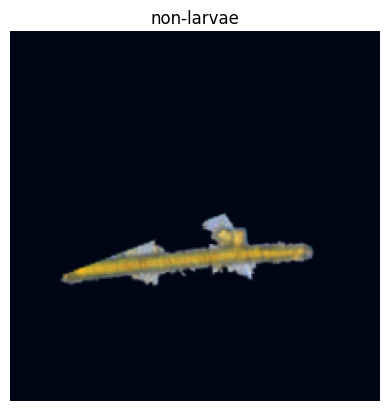

In [6]:
visualize_larvae_sample(train_loader.dataset)

In [7]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(799, 319, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [8]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [9]:
cnn_0 = PretrainedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    backbone="mobilenet_v2",
    use_dropout=True,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [11]:
optimizer_cnn_0 = optim.Adam(cnn_0.parameters(), lr=3e-4)
scheduler_cnn_0 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_0, T_max=50, eta_min=1e-5)
ckpt_cnn_0 = "weights/larvae-pre-cnn-0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [12]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.5907 | Val Loss: 0.5400 | Train cohen_kappa_fn: 0.4080 | Val cohen_kappa_fn: 0.3642 | Train accuracy_fn: 0.7484 | Val accuracy_fn: 0.6991
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.4153 | Val Loss: 0.3679 | Train cohen_kappa_fn: 0.7679 | Val cohen_kappa_fn: 0.7251 | Train accuracy_fn: 0.9399 | Val accuracy_fn: 0.9279
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.2961 | Val Loss: 0.3148 | Train cohen_kappa_fn: 0.8134 | Val cohen_kappa_fn: 0.8103 | Train accuracy_fn: 0.9512 | Val accuracy_fn: 0.9498
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.2585 | Val Loss: 0.2495 | Train cohen_kappa_fn: 0.7756 | Val cohen_kappa_fn: 0.8190 | Train accuracy_fn: 0.9399 | Val accuracy_fn: 0.9498
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.2394 | Val Loss: 0.2343 | Train cohen_kappa_fn: 0.7942 | Val cohen_kappa_fn: 0.7964 | Train accuracy_fn: 0.9462 | Val accuracy_fn: 0.9436
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.2297 | Val Loss: 0.2248 | Train cohen_kappa_fn: 0.8195 | Val cohen_kappa_fn: 0.7995 | Train accuracy_fn: 0.9512 | Val accuracy_fn: 0.9436
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.2217 | Val Loss: 0.2269 | Train cohen_kappa_fn: 0.7721 | Val cohen_kappa_fn: 0.6981 | Train accuracy_fn: 0.9349 | Val accuracy_fn: 0.9028
  ❄️ Performance droped, model won't be saved!


📘 Epoch 8 | Train Loss: 0.1898 | Val Loss: 0.2091 | Train cohen_kappa_fn: 0.7735 | Val cohen_kappa_fn: 0.7746 | Train accuracy_fn: 0.9349 | Val accuracy_fn: 0.9342
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.1959 | Val Loss: 0.2013 | Train cohen_kappa_fn: 0.8102 | Val cohen_kappa_fn: 0.7532 | Train accuracy_fn: 0.9487 | Val accuracy_fn: 0.9279
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.1708 | Val Loss: 0.1885 | Train cohen_kappa_fn: 0.7698 | Val cohen_kappa_fn: 0.7417 | Train accuracy_fn: 0.9337 | Val accuracy_fn: 0.9185
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.2027 | Val Loss: 0.1771 | Train cohen_kappa_fn: 0.8317 | Val cohen_kappa_fn: 0.7515 | Train accuracy_fn: 0.9549 | Val accuracy_fn: 0.9248
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.1848 | Val Loss: 0.1825 | Train cohen_kappa_fn: 0.7883 | Val cohen_kappa_fn: 0.7417 | Train accuracy_fn: 0.9399 | Val accuracy_fn: 0.9185
  ❄️ Performance droped, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1528 | Val Loss: 0.1918 | Train cohen_kappa_fn: 0.8247 | Val cohen_kappa_fn: 0.8025 | Train accuracy_fn: 0.9524 | Val accuracy_fn: 0.9436
  ❄️ Performance droped, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1877 | Val Loss: 0.1823 | Train cohen_kappa_fn: 0.7729 | Val cohen_kappa_fn: 0.7429 | Train accuracy_fn: 0.9362 | Val accuracy_fn: 0.9216
  ❄️ Performance droped, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1693 | Val Loss: 0.1910 | Train cohen_kappa_fn: 0.7883 | Val cohen_kappa_fn: 0.7699 | Train accuracy_fn: 0.9399 | Val accuracy_fn: 0.9279
  ❄️ Performance droped, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1639 | Val Loss: 0.1839 | Train cohen_kappa_fn: 0.8009 | Val cohen_kappa_fn: 0.7533 | Train accuracy_fn: 0.9437 | Val accuracy_fn: 0.9216
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


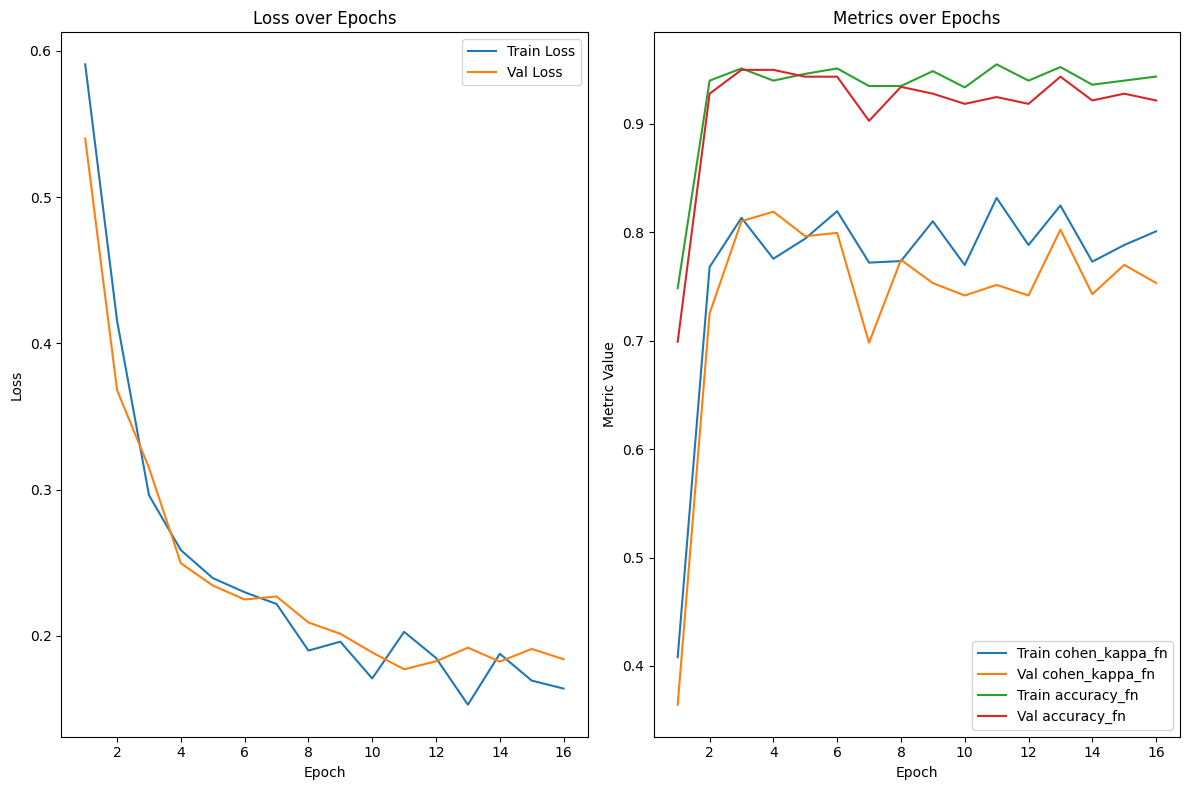

In [13]:
trainer_cnn_0.plot_epochs()

In [14]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1855 | Test cohen_kappa_fn: 0.7763 | Test accuracy_fn: 0.9292


### 3.3. CNN1

In [14]:
cnn_1 = PretrainedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    backbone="squeezenet1_0",
    use_dropout=True,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 109, 109]          14,208
              ReLU-2         [-1, 96, 109, 109]               0
         MaxPool2d-3           [-1, 96, 54, 54]               0
            Conv2d-4           [-1, 16, 54, 54]           1,552
              ReLU-5           [-1, 16, 54, 54]               0
            Conv2d-6           [-1, 64, 54, 54]           1,088
              ReLU-7           [-1, 64, 54, 54]               0
            Conv2d-8           [-1, 64, 54, 54]           9,280
              ReLU-9           [-1, 64, 54, 54]               0
             Fire-10          [-1, 128, 54, 54]               0
           Conv2d-11           [-1, 16, 54, 54]           2,064
             ReLU-12           [-1, 16, 54, 54]               0
           Conv2d-13           [-1, 64, 54, 54]           1,088
             ReLU-14           [-1, 64,

In [ ]:
optimizer_cnn_1 = optim.Adam(cnn_1.parameters(), lr=3e-4)
scheduler_cnn_1 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_1, T_max=50, eta_min=1e-5)
ckpt_cnn_1 = "weights/larvae-pre-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [16]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.3927 | Val Loss: 0.2249 | Train cohen_kappa_fn: 0.7681 | Val cohen_kappa_fn: 0.7807 | Train accuracy_fn: 0.9312 | Val accuracy_fn: 0.9373
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.1962 | Val Loss: 0.1688 | Train cohen_kappa_fn: 0.7760 | Val cohen_kappa_fn: 0.7962 | Train accuracy_fn: 0.9299 | Val accuracy_fn: 0.9404
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.1470 | Val Loss: 0.1543 | Train cohen_kappa_fn: 0.7662 | Val cohen_kappa_fn: 0.7725 | Train accuracy_fn: 0.9249 | Val accuracy_fn: 0.9310
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.1440 | Val Loss: 0.1439 | Train cohen_kappa_fn: 0.8562 | Val cohen_kappa_fn: 0.8417 | Train accuracy_fn: 0.9574 | Val accuracy_fn: 0.9561
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.1275 | Val Loss: 0.1444 | Train cohen_kappa_fn: 0.8777 | Val cohen_kappa_fn: 0.8417 | Train accuracy_fn: 0.9637 | Val accuracy_fn: 0.9561
  ❄️ Performance droped, model won't be saved!


📘 Epoch 6 | Train Loss: 0.1095 | Val Loss: 0.1336 | Train cohen_kappa_fn: 0.8554 | Val cohen_kappa_fn: 0.8519 | Train accuracy_fn: 0.9574 | Val accuracy_fn: 0.9592
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.1063 | Val Loss: 0.1199 | Train cohen_kappa_fn: 0.8010 | Val cohen_kappa_fn: 0.8150 | Train accuracy_fn: 0.9374 | Val accuracy_fn: 0.9467
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.0985 | Val Loss: 0.1208 | Train cohen_kappa_fn: 0.8770 | Val cohen_kappa_fn: 0.8541 | Train accuracy_fn: 0.9637 | Val accuracy_fn: 0.9592
  ❄️ Performance droped, model won't be saved!


📘 Epoch 9 | Train Loss: 0.0842 | Val Loss: 0.1281 | Train cohen_kappa_fn: 0.8617 | Val cohen_kappa_fn: 0.8541 | Train accuracy_fn: 0.9587 | Val accuracy_fn: 0.9592
  ❄️ Performance droped, model won't be saved!


📘 Epoch 10 | Train Loss: 0.0971 | Val Loss: 0.1227 | Train cohen_kappa_fn: 0.8809 | Val cohen_kappa_fn: 0.8541 | Train accuracy_fn: 0.9650 | Val accuracy_fn: 0.9592
  ❄️ Performance droped, model won't be saved!


📘 Epoch 11 | Train Loss: 0.0892 | Val Loss: 0.1182 | Train cohen_kappa_fn: 0.8080 | Val cohen_kappa_fn: 0.7812 | Train accuracy_fn: 0.9399 | Val accuracy_fn: 0.9342
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.0852 | Val Loss: 0.1166 | Train cohen_kappa_fn: 0.9094 | Val cohen_kappa_fn: 0.8852 | Train accuracy_fn: 0.9737 | Val accuracy_fn: 0.9687
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.0726 | Val Loss: 0.1153 | Train cohen_kappa_fn: 0.9083 | Val cohen_kappa_fn: 0.8747 | Train accuracy_fn: 0.9737 | Val accuracy_fn: 0.9655
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.0681 | Val Loss: 0.1131 | Train cohen_kappa_fn: 0.9171 | Val cohen_kappa_fn: 0.8747 | Train accuracy_fn: 0.9762 | Val accuracy_fn: 0.9655
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.0737 | Val Loss: 0.1139 | Train cohen_kappa_fn: 0.9059 | Val cohen_kappa_fn: 0.8747 | Train accuracy_fn: 0.9725 | Val accuracy_fn: 0.9655
  ❄️ Performance droped, model won't be saved!


📘 Epoch 16 | Train Loss: 0.0734 | Val Loss: 0.1086 | Train cohen_kappa_fn: 0.9059 | Val cohen_kappa_fn: 0.8441 | Train accuracy_fn: 0.9725 | Val accuracy_fn: 0.9561
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.0713 | Val Loss: 0.1082 | Train cohen_kappa_fn: 0.9048 | Val cohen_kappa_fn: 0.8958 | Train accuracy_fn: 0.9725 | Val accuracy_fn: 0.9718
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.0637 | Val Loss: 0.1174 | Train cohen_kappa_fn: 0.9212 | Val cohen_kappa_fn: 0.9067 | Train accuracy_fn: 0.9775 | Val accuracy_fn: 0.9749
  ❄️ Performance droped, model won't be saved!


📘 Epoch 19 | Train Loss: 0.0618 | Val Loss: 0.1085 | Train cohen_kappa_fn: 0.8974 | Val cohen_kappa_fn: 0.8441 | Train accuracy_fn: 0.9700 | Val accuracy_fn: 0.9561
  ❄️ Performance droped, model won't be saved!


📘 Epoch 20 | Train Loss: 0.0601 | Val Loss: 0.1138 | Train cohen_kappa_fn: 0.9387 | Val cohen_kappa_fn: 0.9067 | Train accuracy_fn: 0.9825 | Val accuracy_fn: 0.9749
  ❄️ Performance droped, model won't be saved!


📘 Epoch 21 | Train Loss: 0.0528 | Val Loss: 0.1320 | Train cohen_kappa_fn: 0.9369 | Val cohen_kappa_fn: 0.9177 | Train accuracy_fn: 0.9825 | Val accuracy_fn: 0.9781
  ❄️ Performance droped, model won't be saved!


📘 Epoch 22 | Train Loss: 0.0485 | Val Loss: 0.1025 | Train cohen_kappa_fn: 0.9130 | Val cohen_kappa_fn: 0.8958 | Train accuracy_fn: 0.9750 | Val accuracy_fn: 0.9718
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.0549 | Val Loss: 0.1148 | Train cohen_kappa_fn: 0.9468 | Val cohen_kappa_fn: 0.9177 | Train accuracy_fn: 0.9850 | Val accuracy_fn: 0.9781
  ❄️ Performance droped, model won't be saved!


📘 Epoch 24 | Train Loss: 0.0715 | Val Loss: 0.1039 | Train cohen_kappa_fn: 0.9258 | Val cohen_kappa_fn: 0.8958 | Train accuracy_fn: 0.9787 | Val accuracy_fn: 0.9718
  ❄️ Performance droped, model won't be saved!


📘 Epoch 25 | Train Loss: 0.0544 | Val Loss: 0.1098 | Train cohen_kappa_fn: 0.9341 | Val cohen_kappa_fn: 0.8958 | Train accuracy_fn: 0.9812 | Val accuracy_fn: 0.9718
  ❄️ Performance droped, model won't be saved!


📘 Epoch 26 | Train Loss: 0.0506 | Val Loss: 0.1014 | Train cohen_kappa_fn: 0.9019 | Val cohen_kappa_fn: 0.8958 | Train accuracy_fn: 0.9712 | Val accuracy_fn: 0.9718
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.0610 | Val Loss: 0.0882 | Train cohen_kappa_fn: 0.8979 | Val cohen_kappa_fn: 0.8643 | Train accuracy_fn: 0.9700 | Val accuracy_fn: 0.9624
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.0545 | Val Loss: 0.1150 | Train cohen_kappa_fn: 0.9380 | Val cohen_kappa_fn: 0.9067 | Train accuracy_fn: 0.9825 | Val accuracy_fn: 0.9749
  ❄️ Performance droped, model won't be saved!


📘 Epoch 29 | Train Loss: 0.0489 | Val Loss: 0.1178 | Train cohen_kappa_fn: 0.9083 | Val cohen_kappa_fn: 0.8958 | Train accuracy_fn: 0.9737 | Val accuracy_fn: 0.9718
  ❄️ Performance droped, model won't be saved!


📘 Epoch 30 | Train Loss: 0.0580 | Val Loss: 0.0996 | Train cohen_kappa_fn: 0.9380 | Val cohen_kappa_fn: 0.8958 | Train accuracy_fn: 0.9825 | Val accuracy_fn: 0.9718
  ❄️ Performance droped, model won't be saved!


📘 Epoch 31 | Train Loss: 0.0472 | Val Loss: 0.1147 | Train cohen_kappa_fn: 0.9345 | Val cohen_kappa_fn: 0.8958 | Train accuracy_fn: 0.9812 | Val accuracy_fn: 0.9718
  ❄️ Performance droped, model won't be saved!


📘 Epoch 32 | Train Loss: 0.0478 | Val Loss: 0.0993 | Train cohen_kappa_fn: 0.9176 | Val cohen_kappa_fn: 0.8958 | Train accuracy_fn: 0.9762 | Val accuracy_fn: 0.9718
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


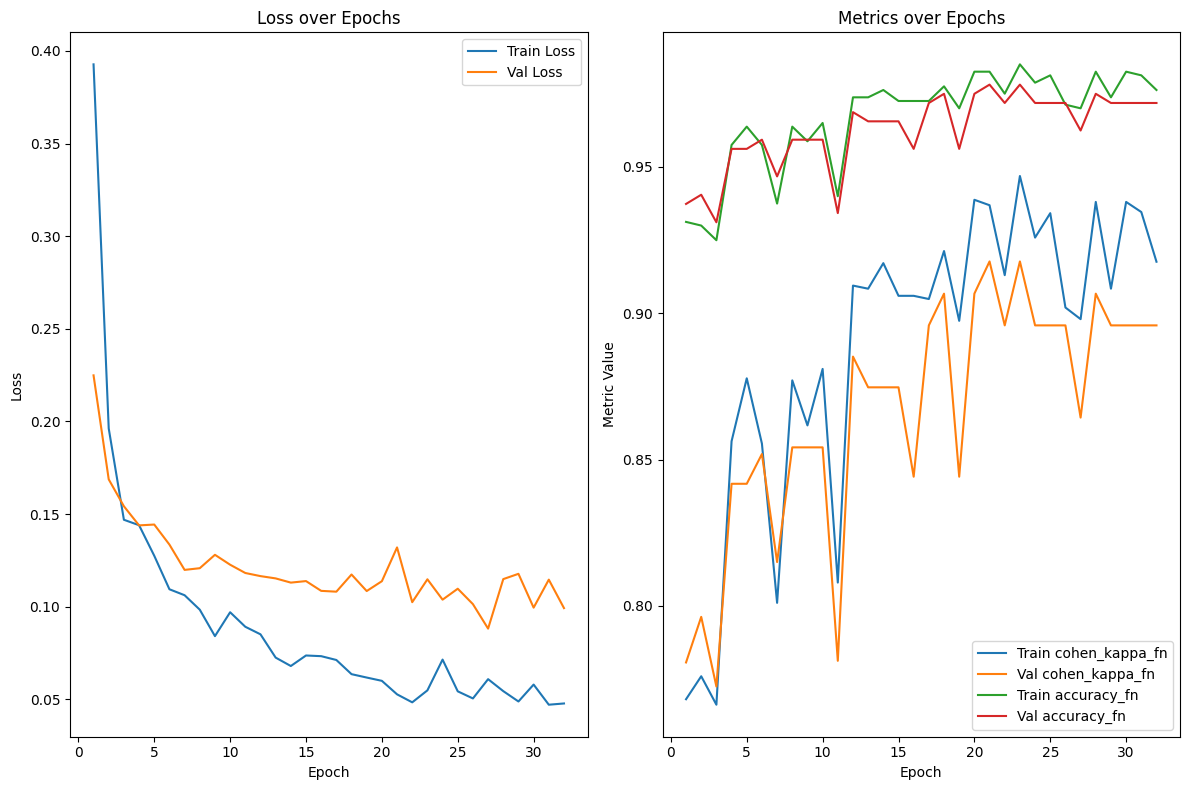

In [17]:
trainer_cnn_1.plot_epochs()

In [ ]:
trainer_cnn_1.train(test_loader)

Test Loss: 0.0888 | Test cohen_kappa_fn: 0.9306 | Test accuracy_fn: 0.9833


### 3.4. CNN2

In [19]:
cnn_2 = PretrainedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    backbone="resnet18",
    use_dropout=True,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
optimizer_cnn_2 = optim.Adam(cnn_2.parameters(), lr=3e-4)
scheduler_cnn_2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_2, T_max=50, eta_min=1e-5)
ckpt_cnn_2 = "weights/larvae-pre-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [21]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.5576 | Val Loss: 0.3855 | Train cohen_kappa_fn: 0.7461 | Val cohen_kappa_fn: 0.7623 | Train accuracy_fn: 0.9274 | Val accuracy_fn: 0.9310
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.3370 | Val Loss: 0.2528 | Train cohen_kappa_fn: 0.7207 | Val cohen_kappa_fn: 0.6792 | Train accuracy_fn: 0.9086 | Val accuracy_fn: 0.8966
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.2603 | Val Loss: 0.2236 | Train cohen_kappa_fn: 0.7114 | Val cohen_kappa_fn: 0.6425 | Train accuracy_fn: 0.9036 | Val accuracy_fn: 0.8809
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.2262 | Val Loss: 0.2052 | Train cohen_kappa_fn: 0.7355 | Val cohen_kappa_fn: 0.7024 | Train accuracy_fn: 0.9161 | Val accuracy_fn: 0.9060
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.2032 | Val Loss: 0.1943 | Train cohen_kappa_fn: 0.7450 | Val cohen_kappa_fn: 0.6759 | Train accuracy_fn: 0.9161 | Val accuracy_fn: 0.8934
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.2060 | Val Loss: 0.2203 | Train cohen_kappa_fn: 0.8680 | Val cohen_kappa_fn: 0.8032 | Train accuracy_fn: 0.9637 | Val accuracy_fn: 0.9467
  ❄️ Performance droped, model won't be saved!


📘 Epoch 7 | Train Loss: 0.1991 | Val Loss: 0.1836 | Train cohen_kappa_fn: 0.8411 | Val cohen_kappa_fn: 0.7604 | Train accuracy_fn: 0.9524 | Val accuracy_fn: 0.9279
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.1884 | Val Loss: 0.1810 | Train cohen_kappa_fn: 0.8098 | Val cohen_kappa_fn: 0.7518 | Train accuracy_fn: 0.9424 | Val accuracy_fn: 0.9248
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.1913 | Val Loss: 0.1761 | Train cohen_kappa_fn: 0.8191 | Val cohen_kappa_fn: 0.7604 | Train accuracy_fn: 0.9449 | Val accuracy_fn: 0.9279
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.1770 | Val Loss: 0.1813 | Train cohen_kappa_fn: 0.8227 | Val cohen_kappa_fn: 0.7604 | Train accuracy_fn: 0.9462 | Val accuracy_fn: 0.9279
  ❄️ Performance droped, model won't be saved!


📘 Epoch 11 | Train Loss: 0.1644 | Val Loss: 0.1939 | Train cohen_kappa_fn: 0.7038 | Val cohen_kappa_fn: 0.6585 | Train accuracy_fn: 0.8986 | Val accuracy_fn: 0.8840
  ❄️ Performance droped, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1527 | Val Loss: 0.1687 | Train cohen_kappa_fn: 0.8469 | Val cohen_kappa_fn: 0.8055 | Train accuracy_fn: 0.9549 | Val accuracy_fn: 0.9436
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.1822 | Val Loss: 0.1764 | Train cohen_kappa_fn: 0.7494 | Val cohen_kappa_fn: 0.6945 | Train accuracy_fn: 0.9199 | Val accuracy_fn: 0.9028
  ❄️ Performance droped, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1448 | Val Loss: 0.1709 | Train cohen_kappa_fn: 0.8438 | Val cohen_kappa_fn: 0.7781 | Train accuracy_fn: 0.9524 | Val accuracy_fn: 0.9342
  ❄️ Performance droped, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1411 | Val Loss: 0.1664 | Train cohen_kappa_fn: 0.8503 | Val cohen_kappa_fn: 0.7348 | Train accuracy_fn: 0.9549 | Val accuracy_fn: 0.9185
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.1619 | Val Loss: 0.1766 | Train cohen_kappa_fn: 0.8185 | Val cohen_kappa_fn: 0.7024 | Train accuracy_fn: 0.9437 | Val accuracy_fn: 0.9060
  ❄️ Performance droped, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1361 | Val Loss: 0.1641 | Train cohen_kappa_fn: 0.8090 | Val cohen_kappa_fn: 0.7024 | Train accuracy_fn: 0.9399 | Val accuracy_fn: 0.9060
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.1502 | Val Loss: 0.1682 | Train cohen_kappa_fn: 0.8849 | Val cohen_kappa_fn: 0.8150 | Train accuracy_fn: 0.9662 | Val accuracy_fn: 0.9467
  ❄️ Performance droped, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1493 | Val Loss: 0.1969 | Train cohen_kappa_fn: 0.9422 | Val cohen_kappa_fn: 0.7835 | Train accuracy_fn: 0.9837 | Val accuracy_fn: 0.9404
  ❄️ Performance droped, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1350 | Val Loss: 0.1912 | Train cohen_kappa_fn: 0.9031 | Val cohen_kappa_fn: 0.8093 | Train accuracy_fn: 0.9725 | Val accuracy_fn: 0.9467
  ❄️ Performance droped, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1614 | Val Loss: 0.1666 | Train cohen_kappa_fn: 0.8524 | Val cohen_kappa_fn: 0.8055 | Train accuracy_fn: 0.9562 | Val accuracy_fn: 0.9436
  ❄️ Performance droped, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1107 | Val Loss: 0.1710 | Train cohen_kappa_fn: 0.8631 | Val cohen_kappa_fn: 0.8245 | Train accuracy_fn: 0.9599 | Val accuracy_fn: 0.9498
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


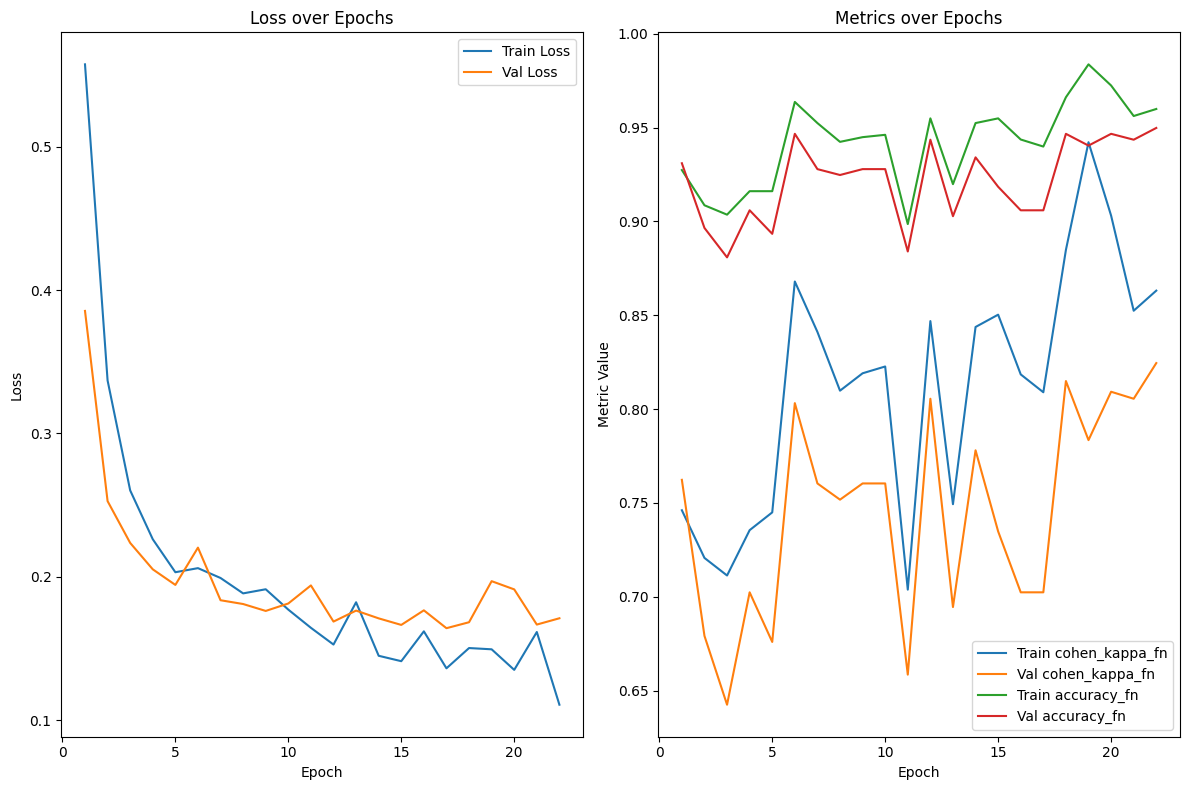

In [22]:
trainer_cnn_2.plot_epochs()

In [ ]:
trainer_cnn_2.train(test_loader)

Test Loss: 0.1625 | Test cohen_kappa_fn: 0.7316 | Test accuracy_fn: 0.9250
